<a href="https://colab.research.google.com/github/ArmandFS/8input-xor-mcpit-ANN/blob/main/PeduliHIV_Hate_Speech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import re
import string

import pandas as pd
import numpy as np

from collections import Counter

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import regularizers
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

os.chdir("/content/drive/Shareddrives/CAPSTONE BANGKIT 2023/Machine Learning/Hate Speech 2")

In [ ]:
main_data=pd.read_csv("train2.csv")
data=main_data.copy()
data.drop(columns=['id'],axis=1,inplace=True)
data

,label,tweet
0,1,- disaat semua cowok berusaha melacak perhatia...
1,1,RT USER: USER siapa yang telat ngasih tau elu?...
2,0,"41. Kadang aku berfikir, kenapa aku tetap perc..."
3,0,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...
4,1,USER USER Kaum cebong kapir udah keliatan dong...
...,...,...
13164,1,USER jangan asal ngomong ndasmu. congor lu yg ...
13165,1,USER Kasur mana enak kunyuk'
13166,0,USER Hati hati bisu :( .g\n\nlagi bosan huft \...
13167,0,USER USER USER USER Bom yang real mudah terdet...


,label
1,7309
0,5860


0s : 1s  ::   0.8 : 1


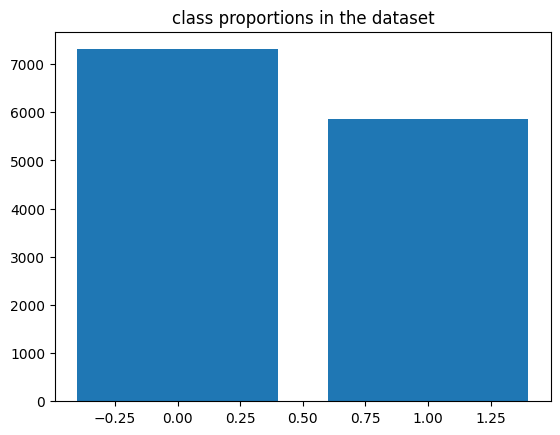

In [ ]:
#Check class distribution in dependent variable
display(data['label'].value_counts().to_frame())
print("0s : 1s  ::  ",(data['label'].value_counts()[0]/data['label'].value_counts()[1]).round(2),": 1")
plt.bar([0,1],data['label'].value_counts())
plt.title("class proportions in the dataset")
plt.show()

#### we see that we have an unbalanced data mojority class to minority class ratio of 13 : 1

,label
1,21927
0,5860


0s : 1s  ::   0.27 : 1


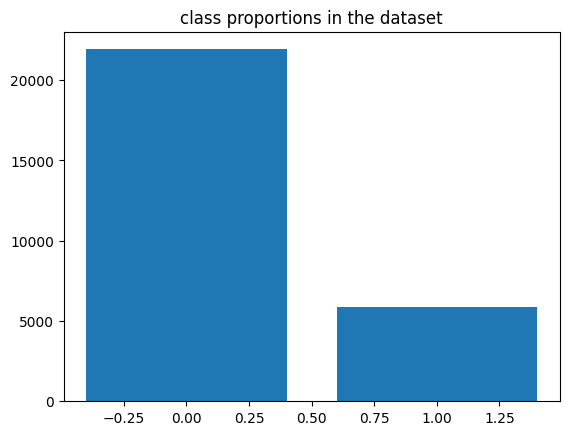

In [ ]:
#Balancing the dataset using Oversampling
data1=data[data['label']==1]
data0=data[data['label']==0]
data=pd.concat([data,data1,data1], axis=0)
data

#Check class distribution in dependent variable again
display(data['label'].value_counts().to_frame())
print("0s : 1s  ::  ",(data['label'].value_counts()[0]/data['label'].value_counts()[1]).round(2),": 1")
plt.bar([0,1],data['label'].value_counts())
plt.title("class proportions in the dataset")
plt.show()

In [ ]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

    return emoji_pattern.sub(r'', text)


def clean_text(text ):
    delete_dict = {sp_character: '' for sp_character in string.punctuation}
    delete_dict[' '] = ' '
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>3))])

    return text2.lower()

In [ ]:
#preprocess train dataset
data['tweet'] = data['tweet'].apply(remove_emoji)
data['tweet'] = data['tweet'].apply(clean_text)
data['Num_words_text'] = data['tweet'].apply(lambda x:len(str(x).split()))

train_data,test_data= train_test_split(data, test_size=0.2)
train_data.reset_index(drop=True,inplace=True)
test_data.reset_index(drop=True,inplace=True)

In [ ]:
#classes proportion in dependent variable in train and test dataset
print('===========Train Data =========')
print(train_data['label'].value_counts())
print(len(train_data))
print('==============================')

print('===========Test Data =========')
print(test_data['label'].value_counts())
print(len(test_data))
print('==============================')

===========Train Data =========
1    5832
0    4703
Name: label, dtype: int64
10535
===========Test Data =========
1    1477
0    1157
Name: label, dtype: int64
2634


In [ ]:
#train and validation dataset splitting
X_train, X_valid, y_train, y_valid = train_test_split(train_data['tweet'].tolist(),\
                                                      train_data['label'].tolist(),\
                                                      test_size=0.2,\
                                                      stratify = train_data['label'].tolist(),\
                                                      random_state=0)


print('Train data len:'+str(len(X_train)))
print('Class distribution'+str(Counter(y_train)))
print('Valid data len:'+str(len(X_valid)))
print('Class distribution'+ str(Counter(y_valid)))

Train data len:8428
Class distributionCounter({1: 4666, 0: 3762})
Valid data len:2107
Class distributionCounter({1: 1166, 0: 941})


In [ ]:
num_words = 50000

tokenizer = Tokenizer(num_words=num_words,oov_token="unk")
tokenizer.fit_on_texts(X_train)

In [ ]:
#convert sentences to sequences of numbers
x_train = np.array( tokenizer.texts_to_sequences(X_train) )
x_valid = np.array( tokenizer.texts_to_sequences(X_valid) )
x_test  = np.array( tokenizer.texts_to_sequences(test_data['tweet'].tolist()) )

#padding
maxlen=50
x_train = pad_sequences(x_train, padding='post', maxlen=maxlen)
x_valid = pad_sequences(x_valid, padding='post', maxlen=maxlen)
x_test = pad_sequences(x_test, padding='post', maxlen=maxlen)


train_labels = np.asarray(y_train)
valid_labels = np.asarray(y_valid)
test_labels = np.asarray(test_data['label'].tolist())


print('Train data len:'+str(len(x_train)))
print('Class distribution'+str(Counter(train_labels)))

print('Validation data len:'+str(len(x_valid)))
print('Class distribution'+str(Counter(valid_labels)))

print('Test data len:'+str(len(x_test)))
print('Class distribution'+str(Counter(test_labels)))

#tensorflow dataset preparation
train_ds = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid,valid_labels))
test_ds = tf.data.Dataset.from_tensor_slices((x_test,test_labels))

Train data len:8428
Class distributionCounter({1: 4666, 0: 3762})
Validation data len:2107
Class distributionCounter({1: 1166, 0: 941})
Test data len:2634
Class distributionCounter({1: 1477, 0: 1157})


In [ ]:
count =0
print('======Train dataset ====')
for value,label in train_ds:
    count += 1
    print(value,label)
    if count==1:
        break
count =0
print('======Validation dataset ====')
for value,label in valid_ds:
    count += 1
    print(value,label)
    if count==1:
        break
count =0
print('======Test dataset ====')
for value,label in test_ds:
    count += 1
    print(value,label)
    if count==1:
        break

======Train dataset ====
tf.Tensor(
[1944 1945 2183  806 3758  615   60 3759 2184 7874    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0], shape=(50,), dtype=int32) tf.Tensor(0, shape=(), dtype=int64)
======Validation dataset ====
tf.Tensor(
[ 1379 22099    46    44   419    16  1181   120     4     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0], shape=(50,), dtype=int32) tf.Tensor(1, shape=(), dtype=int64)
======Test dataset ====
tf.Tensor(
[   5    1   24   39  164 6031  721   60    3   39  164   24 2099    3
 5005 2255    1    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    

In [ ]:
#model preparation
max_features =50000
embedding_dim =16
sequence_length = maxlen

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(max_features +1, embedding_dim, input_length=sequence_length,\
                                    embeddings_regularizer = regularizers.l2(0.005)))
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.LSTM(embedding_dim,dropout=0.2, recurrent_dropout=0.2,return_sequences=True,\
                                                             kernel_regularizer=regularizers.l2(0.005),\
                                                             bias_regularizer=regularizers.l2(0.005)))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(512, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.Dense(8, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
model.add(tf.keras.layers.Dropout(0.4))


model.add(tf.keras.layers.Dense(1,activation='sigmoid'))




model.summary()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),optimizer=tf.keras.optimizers.Adam(1e-3),metrics=[tf.keras.metrics.BinaryAccuracy()])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            800016    
                                                                 
 dropout (Dropout)           (None, 50, 16)            0         
                                                                 
 lstm (LSTM)                 (None, 50, 16)            2112      
                                                                 
 flatten (Flatten)           (None, 800)               0         
                                                                 
 dense (Dense)               (None, 512)               410112    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 4

In [ ]:
epochs = 50
# Fit the model using the train and test datasets.
history = model.fit(train_ds.shuffle(5000).batch(1024),
                    epochs= epochs ,
                    validation_data=valid_ds.batch(1024),
                    verbose=1)

Epoch 1/50
9/9 [==============================] - 8s 485ms/step - loss: 4.1250 - binary_accuracy: 0.5516 - val_loss: 3.1618 - val_binary_accuracy: 0.5534
Epoch 2/50
9/9 [==============================] - 2s 264ms/step - loss: 2.6771 - binary_accuracy: 0.5826 - val_loss: 2.0692 - val_binary_accuracy: 0.6393
Epoch 3/50
9/9 [==============================] - 2s 266ms/step - loss: 1.7827 - binary_accuracy: 0.6228 - val_loss: 1.4329 - val_binary_accuracy: 0.6346
Epoch 4/50
9/9 [==============================] - 2s 256ms/step - loss: 1.2794 - binary_accuracy: 0.6279 - val_loss: 1.0943 - val_binary_accuracy: 0.6379
Epoch 5/50
9/9 [==============================] - 2s 265ms/step - loss: 1.0201 - binary_accuracy: 0.6423 - val_loss: 0.9268 - val_binary_accuracy: 0.6421
Epoch 6/50
9/9 [==============================] - 5s 608ms/step - loss: 0.8889 - binary_accuracy: 0.6561 - val_loss: 0.8388 - val_binary_accuracy: 0.6550
Epoch 7/50
9/9 [==============================] - 2s 270ms/step - loss: 0.82

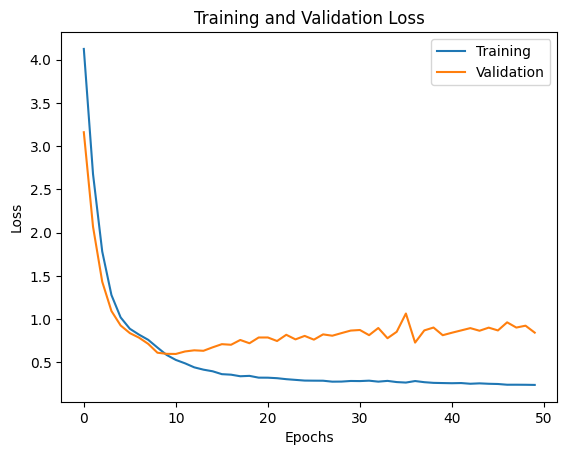

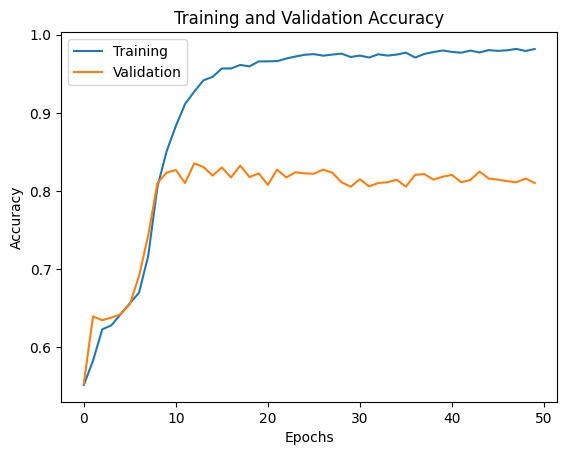

In [ ]:
#Plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.show()

#Plot training and validation accuracy
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.show()

In [ ]:
#make predictions on validation dataset
valid_predict= model.predict(x_valid)
print(valid_predict[:10])

139/139 [==============================] - 1s 8ms/step
[[3.78246506e-04]
 [9.99991417e-01]
 [1.19785305e-04]
 [9.99988258e-01]
 [9.99995828e-01]
 [9.99996543e-01]
 [9.99965012e-01]
 [1.00000000e+00]
 [9.99999940e-01]
 [4.54815388e-01]]


In [ ]:
#model's metrics on test dataset
x_test  = np.array( tokenizer.texts_to_sequences(test_data['tweet'].tolist()) )
x_test = pad_sequences(x_test, padding='post', maxlen=maxlen)


#Generate predictions for all samples
predictions = model.predict(x_test)

174/174 [==============================] - 1s 6ms/step


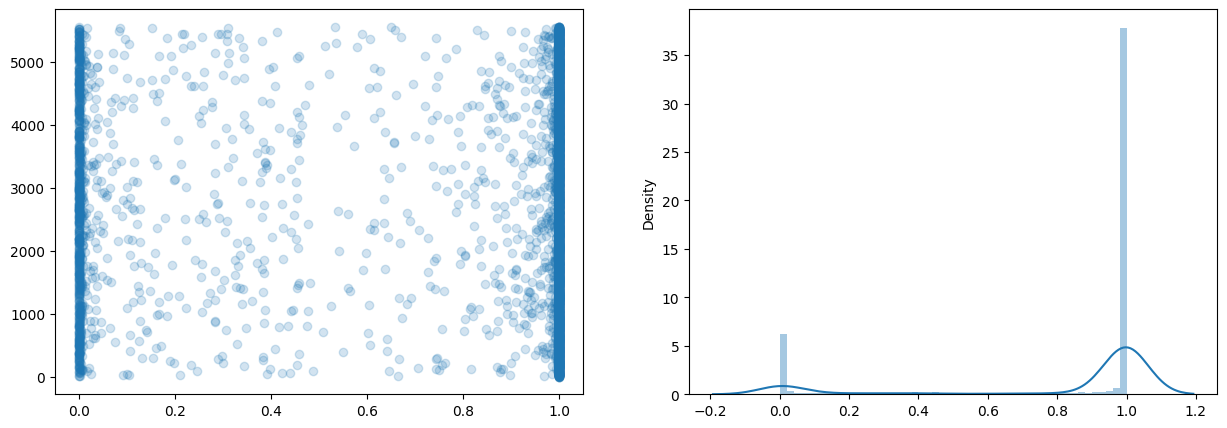

In [ ]:
#plot predictions
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
ax1.scatter(predictions,range(0,len(predictions)),alpha=0.2)
ax2=sns.distplot(predictions)

#### A receiver operating characteristic curve, or ROC curve, is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied

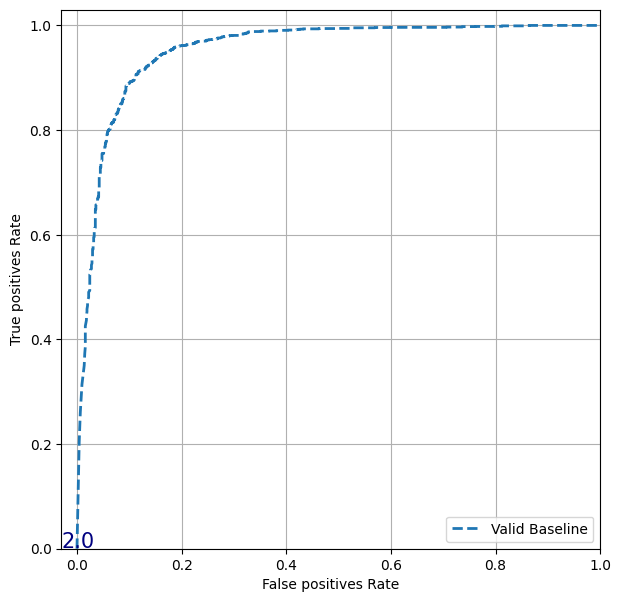

In [ ]:
#decide the cutoff for classifying the predicted probabilities as 1 or 0
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, thresholds = sklearn.metrics.roc_curve(labels, predictions)
    plt.plot(fp, tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives Rate')
    plt.ylabel('True positives Rate')
    plt.xlim([-0.03, 1.0])
    plt.ylim([0.0, 1.03])
    plt.grid(True)
    thresholdsLength = len(thresholds)
    thresholds_every = 1000
    colorMap = plt.get_cmap('jet', thresholdsLength)
    for i in range(0, thresholdsLength, thresholds_every):
        threshold_value_with_max_four_decimals = str(thresholds[i])[:5]
        plt.text(fp[i] - 0.03, tp[i] + 0.001, threshold_value_with_max_four_decimals, fontdict={'size': 15}, color=colorMap(i/thresholdsLength));

    ax = plt.gca()
    ax.set_aspect('equal')

mpl.rcParams['figure.figsize'] = (7,7)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plot_roc("Valid Baseline", valid_labels, valid_predict, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

In [ ]:
cutoff=0.86
test_data['pred_sentiment']= predictions
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment >= cutoff),1,test_data.pred_sentiment)
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment < cutoff),0,test_data.pred_sentiment)

labels = [0, 1]
print(classification_report(test_data['label'].tolist(),test_data['pred_sentiment'].tolist(),labels=labels))

              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1157
           1       0.96      0.96      0.96      4401

    accuracy                           0.93      5558
   macro avg       0.90      0.90      0.90      5558
weighted avg       0.93      0.93      0.93      5558



In [ ]:
x_valid

array([[   71, 19672,   904, ...,     0,     0,     0],
       [ 1207,   108,    44, ...,     0,     0,     0],
       [22066,    14,     1, ...,     0,     0,     0],
       ...,
       [25248, 25249,  2411, ...,     0,     0,     0],
       [    2,     2,   168, ...,     0,     0,     0],
       [    2,     2,   168, ...,     0,     0,     0]], dtype=int32)

## TESTING MODEL ON THE TEST DATASET PROVIDED

In [ ]:
final_test=pd.read_csv("test.csv")

ftest=final_test.copy()
ftest.drop(columns=['id'],axis=1,inplace=True)

ftest['tweet'] = ftest['tweet'].apply(remove_emoji)
ftest['tweet'] = ftest['tweet'].apply(clean_text)

f_test  = np.array( tokenizer.texts_to_sequences(ftest['tweet'].tolist()) )
f_test = pad_sequences(f_test, padding='post', maxlen=maxlen)

#display((x_test))
display((f_test))

array([[  463,   527,    21, ...,     0,     0,     0],
       [ 9751,   227,  3693, ...,     0,     0,     0],
       [17214, 17215, 11689, ...,     0,     0,     0],
       ...,
       [    2,     2,    13, ...,     0,     0,     0],
       [20614,  6615,  7148, ...,     0,     0,     0],
       [ 4112,    18,    48, ...,     0,     0,     0]], dtype=int32)

array([[1107,   70,  181,   71,   70,   23,  779,  150,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [ 125,   51,    6,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [ 983,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,   

In [ ]:
#predict on actual test data
predictions = model.predict(f_test)

1/1 [==============================] - 0s 31ms/step


In [ ]:
predictions

array([[0.9521406 ],
       [0.99960023],
       [0.01221049],
       [0.02589851],
       [0.17638034],
       [0.55851144]], dtype=float32)

In [ ]:
#mapping prediction to 1 or 0
ftest['pred_sentiment']= predictions
ftest['pred_sentiment'] = np.where((ftest.pred_sentiment >= cutoff),1,ftest.pred_sentiment)
ftest['pred_sentiment'] = np.where((ftest.pred_sentiment < cutoff),0,ftest.pred_sentiment)

#processed tweets categorized as hate speech
pd.set_option('display.max_colwidth', None)
ftest[ftest['pred_sentiment']==1]

,tweet,pred_sentiment
0,seharusnya kamu mati saja kamu tidak layak hidup,1.0
1,anjing banget orang,1.0


In [ ]:
#actual tweets categorized as hate speech
final_test.iloc[ftest[ftest['pred_sentiment']==1].index]

,id,tweet
0,21,Seharusnya kamu mati saja! kamu tidak layak hidup
1,233,anjing banget ni orang


#Save model to H5

In [ ]:
model.save('hate_speech_model.h5')

In [ ]:
from google.colab import files
files.download('hate_speech_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>